# Scene Classification

## 3. Build Model-InceptionV3 BatchTrain Top2Layer
- Import pkg
- Load sample data, only first 1000 objects
- 
Reference:
- https://challenger.ai/competitions
- https://github.com/jupyter/notebook/issues/2287

**Tensorboard**
1. Input at command:  **tensorboard --logdir=./log**
2. Input at browser:  **http://127.0.0.1:6006**

### Import pkg

In [1]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [3]:
# import zipfile
import os
import zipfile
import math
import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Load sample data, only first 1000 objects

In [4]:
input_path = './input'
datasetName = 'train'
date = '20170904'

zip_path = input_path + '/ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date)
extract_path = input_path + '/ai_challenger_scene_{0}_{1}'.format(datasetName, date)
image_path = extract_path + '/scene_{0}_images_{1}'.format(datasetName, date)
scene_classes_path = extract_path + '/scene_classes.csv'
scene_annotations_path = extract_path + '/scene_{0}_annotations_{1}.json'.format(datasetName, date)

print(input_path)
print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

./input
./input/ai_challenger_scene_train_20170904.zip
./input/ai_challenger_scene_train_20170904
./input/ai_challenger_scene_train_20170904/scene_train_images_20170904
./input/ai_challenger_scene_train_20170904/scene_classes.csv
./input/ai_challenger_scene_train_20170904/scene_train_annotations_20170904.json


In [5]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [6]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


In [7]:
def load_pickle_data(dataset, index):
    pickleFolder = './input/pickle_{0}'.format(dataset)
    print(pickleFolder)
    x_path = pickleFolder + '/x_data{0}.p'.format(index)
    y_path = pickleFolder + '/y_data{0}.p'.format(index)
    print(x_path)
    print(y_path)
    if not os.path.exists(x_path):
        print(x_path + ' do not exist!')
        return
    if not os.path.exists(y_path):
        print(y_path + ' do not exist!')
        return
    x_data = pickle.load(open(x_path, mode='rb'))
    y_data = pickle.load(open(y_path, mode='rb'))
#     y_data = to_categorical(y_train)
    print(x_data.shape)
    print(y_data.shape)
    return (x_data, y_data)

x_train, y_train = load_pickle_data("train", 0)
print(x_train.shape)
print(y_train.shape)
del x_train
del y_train

./input/pickle_train
./input/pickle_train/x_data0.p
./input/pickle_train/y_data0.p
(1024, 224, 224, 3)
(1024,)
(1024, 224, 224, 3)
(1024,)


./input/pickle_train
./input/pickle_train/x_data0.p
./input/pickle_train/y_data0.p
(1024, 224, 224, 3)
(1024,)
Wall time: 2.37 s


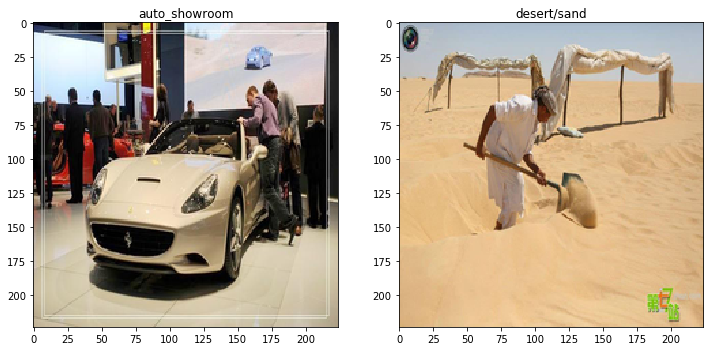

In [8]:
%%time
x_train, y_train = load_pickle_data("train", 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_train[0])
ax[0].set_title(get_scene_name(y_train[0], scene_classes_path))
ax[1].imshow(x_train[1])
ax[1].set_title(get_scene_name(y_train[1], scene_classes_path))
del x_train
del y_train

./input/pickle_validation
./input/pickle_validation/x_data0.p
./input/pickle_validation/y_data0.p
(1024, 224, 224, 3)
(1024,)
Wall time: 12.7 s


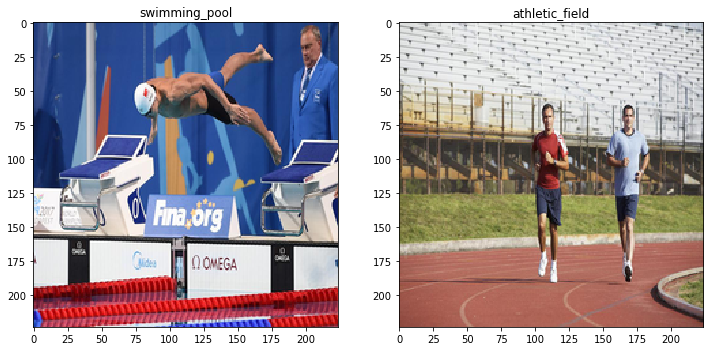

In [9]:
%%time
x_val, y_val = load_pickle_data("validation", 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_val[0])
ax[0].set_title(get_scene_name(y_val[0], scene_classes_path))
ax[1].imshow(x_val[1])
ax[1].set_title(get_scene_name(y_val[1], scene_classes_path))
del x_val
del y_val

### Load model

In [10]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(80, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [12]:
def saveModel(model, middleName):
    modelPath = './model'
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
        
    fileName = middleName + time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    jsonFileName = modelPath + '/' + fileName + '.json'
    yamlFileName = modelPath + '/' + fileName + '.yaml'

    json_string = model.to_json()
    with open(jsonFileName, 'w') as file:
        file.write(json_string)
    yaml_string = model.to_yaml()
    with open(yamlFileName, 'w') as file:
        file.write(yaml_string)
    
    weigthsFile = modelPath + '/' + fileName + '.h5'
    model.save(weigthsFile)
# saveModel(model, 'ModelSaveTest')

**Train top 2 inception**

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
train_generator = train_datagen.flow_from_directory('./input/data_train',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode = "categorical")
print(train_generator.classes[0:1000])

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
tensorBoard = TensorBoard(log_dir='./log_Top2Inc_171001')

Found 53879 images belonging to 80 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [14]:
x_val, y_val = load_pickle_data("validation", 0)
y_val = to_categorical(y_val)

# model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                       steps_per_epoch=128,
                       epochs=32, #Increase this when not on Kaggle kernel
                       verbose=2,  #1 for ETA, 0 for silent
                       validation_data=(x_val, y_val),
                       callbacks=[tensorBoard])

./input/pickle_validation
./input/pickle_validation/x_data0.p
./input/pickle_validation/y_data0.p
(1024, 224, 224, 3)
(1024,)
Epoch 1/32
339s - loss: 4.1847 - acc: 0.0697 - val_loss: 3.7169 - val_acc: 0.1875
Epoch 2/32
320s - loss: 3.7067 - acc: 0.1722 - val_loss: 3.1554 - val_acc: 0.2686
Epoch 3/32
312s - loss: 3.3061 - acc: 0.2347 - val_loss: 2.7992 - val_acc: 0.3418
Epoch 4/32
305s - loss: 3.0818 - acc: 0.2697 - val_loss: 2.5847 - val_acc: 0.3584
Epoch 5/32
301s - loss: 2.9459 - acc: 0.2914 - val_loss: 2.4418 - val_acc: 0.3926
Epoch 6/32
295s - loss: 2.8315 - acc: 0.3069 - val_loss: 2.3261 - val_acc: 0.4033
Epoch 7/32
246s - loss: 2.7158 - acc: 0.3240 - val_loss: 2.2578 - val_acc: 0.4219
Epoch 8/32
199s - loss: 2.6857 - acc: 0.3303 - val_loss: 2.1862 - val_acc: 0.4434
Epoch 9/32
195s - loss: 2.6110 - acc: 0.3438 - val_loss: 2.1396 - val_acc: 0.4639
Epoch 10/32
196s - loss: 2.5723 - acc: 0.3630 - val_loss: 2.1200 - val_acc: 0.4590
Epoch 11/32
212s - loss: 2.5516 - acc: 0.3580 - val_l

In [15]:
saveModel(model, 'TrainImageFolder')

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 1.8433, final accuracy: 0.5264


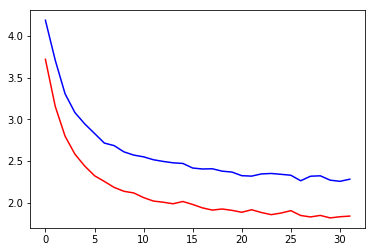

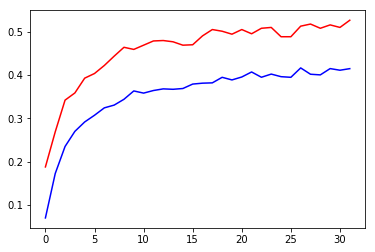

In [17]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [18]:
print('Done!')

Done!
